In [ ]:
# Notebook 4 — VGG16 Transfer Learning (7-class)
# Colab-ready. Run top-to-bottom.

# 0) Imports & environment checks
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg_preprocess
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))



TensorFlow: 2.19.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# 1) GPU safety (prevent TF from grabbing all memory)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Enabled memory growth on GPU(s).")
    except Exception as e:
        print("Could not set memory growth:", e)



Enabled memory growth on GPU(s).


In [ ]:
# 2) Config (update paths if needed)

IMAGE_FOLDER = "/content/drive/MyDrive/HAM10000_images"   # where images live (Notebook1 should have created/cleaned this)
SPLITS_DIR = "/content/drive/MyDrive/splits"
OUTPUT_DIR = "/content/drive/MyDrive/models"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 25
RANDOM_STATE = 42
NUM_CLASSES = 7



In [ ]:
# 3) Load CSV splits
df_train = pd.read_csv(os.path.join(SPLITS_DIR, "df_train.csv"))
df_val   = pd.read_csv(os.path.join(SPLITS_DIR, "df_val.csv"))
df_test  = pd.read_csv(os.path.join(SPLITS_DIR, "df_test.csv"))
print("Train rows:", len(df_train), "Val rows:", len(df_val), "Test rows:", len(df_test))



Train rows: 29491 Val rows: 861 Test rows: 1780


In [ ]:
# 4) Ensure filepath column exists (create if missing)
for d in [df_train, df_val, df_test]:
    if 'filepath' not in d.columns:
        d['filename'] = d['image_id'].astype(str) + '.jpg'
        d['filepath'] = d['filename'].apply(lambda x: os.path.join(IMAGE_FOLDER, x))



In [ ]:
# 5) Sanity check classes
if 'dx' not in df_train.columns:
    raise ValueError("Expected column 'dx' in CSVs with class labels (7 classes).")
print("Train label counts:\n", df_train['dx'].value_counts())



Train label counts:
 dx
bcc      4213
bkl      4213
df       4213
vasc     4213
nv       4213
mel      4213
akiec    4213
Name: count, dtype: int64


In [ ]:
# 6) Generators — use VGG preprocessing (ImageNet mean subtraction / scaling)
train_datagen = ImageDataGenerator(
    preprocessing_function=vgg_preprocess,
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.10,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=vgg_preprocess)
test_datagen = ImageDataGenerator(preprocessing_function=vgg_preprocess)

train_flow = train_datagen.flow_from_dataframe(
    df_train, x_col='filepath', y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE), color_mode='rgb',
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True
)

val_flow = val_datagen.flow_from_dataframe(
    df_val, x_col='filepath', y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE), color_mode='rgb',
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False
)

test_flow = test_datagen.flow_from_dataframe(
    df_test, x_col='filepath', y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE), color_mode='rgb',
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False
)

print("Class indices:", train_flow.class_indices)



Found 29491 validated image filenames belonging to 7 classes.
Found 861 validated image filenames belonging to 7 classes.
Found 1780 validated image filenames belonging to 7 classes.
Class indices: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [ ]:
# 7) Build model: VGG16 (include_top=False) + GAP + Dense(256) + Dropout + Dense(num_classes)
base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
# Freeze most layers. We will unfreeze last few if we fine-tune later.
for layer in base_vgg.layers[:-4]:
    layer.trainable = False

x = base_vgg.output
x = GlobalAveragePooling2D(name='gap')(x)   # -> (512,)
x = Dense(256, activation='relu', name='dense_256')(x)
x = Dropout(0.5, name='dropout')(x)
preds = Dense(NUM_CLASSES, activation='softmax', name='preds')(x)

vgg_model = Model(inputs=base_vgg.input, outputs=preds)
vgg_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model.summary()



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 7,212,551 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
# 8) Callbacks & checkpointing
checkpoint_path = os.path.join(OUTPUT_DIR, "vgg16_best.h5")
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
]



In [ ]:
# 9) Train (head-only first)
history = vgg_model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=EPOCHS,
    callbacks=callbacks
)




/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5447 - loss: 1.2213
Epoch 1: val_loss improved from inf to 0.89059, saving model to /content/drive/MyDrive/models/vgg16_best.h5


922/922 ━━━━━━━━━━━━━━━━━━━━ 3321s 4s/step - accuracy: 0.5449 - loss: 1.2209 - val_accuracy: 0.7027 - val_loss: 0.8906 - learning_rate: 1.0000e-04
Epoch 2/25
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.8942 - loss: 0.3006
Epoch 2: val_loss improved from 0.89059 to 0.78332, saving model to /content/drive/MyDrive/models/vgg16_best.h5


922/922 ━━━━━━━━━━━━━━━━━━━━ 636s 689ms/step - accuracy: 0.8942 - loss: 0.3006 - val_accuracy: 0.7329 - val_loss: 0.7833 - learning_rate: 1.0000e-04
Epoch 3/25
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9443 - loss: 0.1620
Epoch 3: val_loss did not improve from 0.78332
922/922 ━━━━━━━━━━━━━━━━━━━━ 641s 695ms/step - accuracy: 0.9443 - loss: 0.1620 - val_accuracy: 0.7677 - val_loss: 0.8043 - learning_rate: 1.0000e-04
Epoch 4/25
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.9635 - loss: 0.1095
Epoch 4: val_loss did not improve from 0.78332
922/922 ━━━━━━━━━━━━━━━━━━━━ 636s 689ms/step - accuracy: 0.9635 - loss: 0.1094 - val_accuracy: 0.7782 - val_loss: 0.9547 - learning_rate: 1.0000e-04
Epoch 5/25
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9710 - loss: 0.0920
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.

Epoch 5: val_loss did not improve from 0.78332
922/922 ━━━━━━━━━━━━━━━━━━━━ 644s 699ms/step - accuracy: 0.9710 - loss

In [ ]:
# 10) Save last weights & model
vgg_model.save(os.path.join(OUTPUT_DIR, "vgg16_last.h5"))
print("Saved VGG16 models to", OUTPUT_DIR)



Saved VGG16 models to /content/drive/MyDrive/models


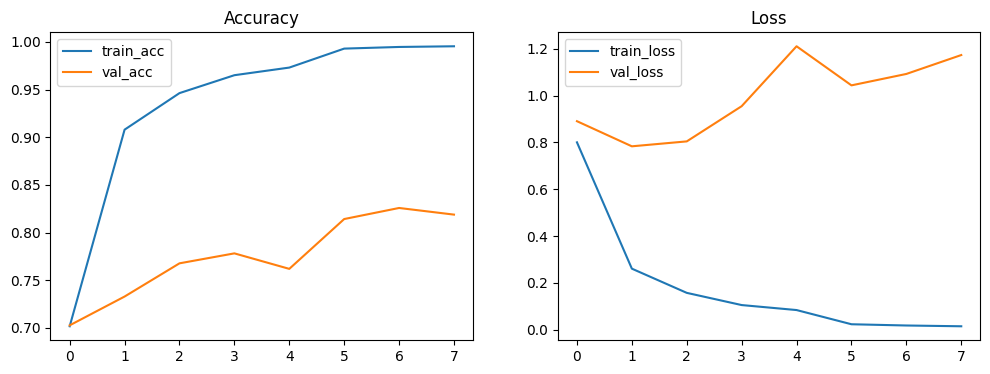

In [ ]:
# 11) Plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.show()



56/56 ━━━━━━━━━━━━━━━━━━━━ 654s 12s/step - accuracy: 0.7546 - loss: 0.8669
Test accuracy: 72.64%, test loss: 0.9090
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 344ms/step

Classification Report (VGG16 Transfer):
              precision    recall  f1-score   support

       akiec     0.5143    0.3333    0.4045        54
         bcc     0.6289    0.6854    0.6559        89
         bkl     0.4873    0.7512    0.5912       205
          df     0.4762    0.4762    0.4762        21
         mel     0.4012    0.6182    0.4866       220
          nv     0.9414    0.7677    0.8457      1171
        vasc     0.8824    0.7500    0.8108        20

    accuracy                         0.7264      1780
   macro avg     0.6188    0.6260    0.6101      1780
weighted avg     0.7876    0.7264    0.7444      1780



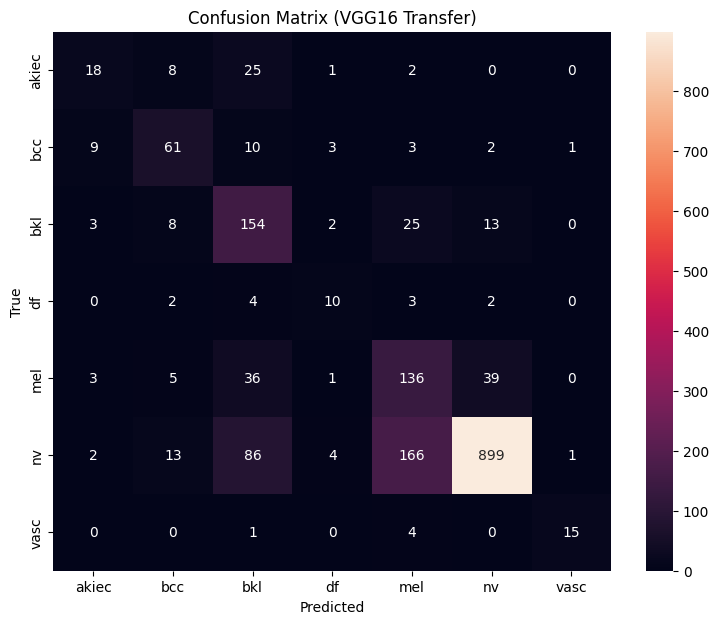

In [ ]:
# 12) Evaluate best model on test set
best = load_model(checkpoint_path)
test_steps = int(np.ceil(test_flow.n / test_flow.batch_size))
loss, acc = best.evaluate(test_flow, steps=test_steps, verbose=1)
print(f"Test accuracy: {acc*100:.2f}%, test loss: {loss:.4f}")

# 13) Predictions -> confusion matrix and classification report
test_flow.reset()
y_prob = best.predict(test_flow, steps=test_steps, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_flow.classes  # integer indices

inv_class_map = {v:k for k,v in train_flow.class_indices.items()}
y_pred_labels = [inv_class_map[int(i)] for i in y_pred]
y_true_labels = [inv_class_map[int(i)] for i in y_true]

print("\nClassification Report (VGG16 Transfer):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=list(inv_class_map.values()))
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(inv_class_map.values()), yticklabels=list(inv_class_map.values()))
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix (VGG16 Transfer)')
plt.show()



In [ ]:
# 14) Optional: Fine-tune last K layers (unfreeze and retrain with lower LR)
# If you want to fine-tune, uncomment and run the following block AFTER the head-only training above
"""
# Unfreeze last N layers (e.g., last 8 conv layers)
N = 8
for layer in base_vgg.layers[-N:]:
    layer.trainable = True

# Recompile with lower LR
vgg_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
vgg_finetune_history = vgg_model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=10,
    callbacks=get_callbacks(os.path.join(OUTPUT_DIR, "vgg16_finetune_best.h5"))
)
# Save finetuned model
vgg_model.save(os.path.join(OUTPUT_DIR, "vgg16_finetuned.h5"))
"""



In [ ]:
# 15) Inference helper (upload images in Colab and run)
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_single_vgg(model, img_path, target_size=(IMG_SIZE,IMG_SIZE)):
    img = load_img(img_path, target_size=target_size)
    arr = img_to_array(img)  # in 0..255
    arr = np.expand_dims(arr, axis=0)
    arr = vgg_preprocess(arr)  # apply same preprocessing as training
    prob = model.predict(arr)[0]
    idx = np.argmax(prob)
    label = inv_class_map[idx]
    return label, prob[idx], prob

print("To run inference: upload a file using files.upload()")
uploaded = files.upload()
for fn in uploaded.keys():
    label, conf, allprob = predict_single_vgg(best, fn)
    print(f"File: {fn}  -> Predicted: {label} ({conf*100:.2f}%)")
    print("All class probs:", {inv_class_map[i]: float(allprob[i]) for i in range(len(allprob))})


To run inference: upload a file using files.upload()


Saving non.png to non.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
File: non.png  -> Predicted: bcc (67.41%)
All class probs: {'akiec': 0.0026421307120472193, 'bcc': 0.6740638017654419, 'bkl': 0.2848854660987854, 'df': 1.450542731618043e-05, 'mel': 0.03812523931264877, 'nv': 0.0002253374841529876, 'vasc': 4.344941407907754e-05}
